#Installing required dependencies

In [1]:
import requests
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter

from tensorflow.keras import layers, models, Input
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from ast import literal_eval
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Downloading Dataset

In [3]:
dataset_url = "https://www.federalregister.gov/api/v1/documents"
params = {"format": "json", "per_page": 2000}

docs = []
total_documents = 10000
downloaded = 0

while downloaded < total_documents:
    response = requests.get(dataset_url, params=params)
    if response.status_code == 200:
        data = response.json()
        results = data.get("results", [])
        docs.extend(results)
        downloaded += len(results)
        dataset_url = data.get("next_page_url")
        if not dataset_url:
            break
    else:
        print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")
        break

total_docs = docs[:total_documents]
with open("federal_register.json", "w", encoding="utf-8") as file:
    json.dump(total_docs, file, ensure_ascii=False)
print(f"Successfully downloaded {len(total_docs)} documents to 'federal_register.json'")

Successfully downloaded 10000 documents to 'federal_register.json'


In [4]:
data_set = pd.read_json('federal_register.json')
data_set.head()

,title,type,abstract,document_number,html_url,pdf_url,public_inspection_pdf_url,publication_date,agencies,excerpts
0,Meeting of the Advisory Committee on Minority ...,Notice,As stipulated by the Federal Advisory Committe...,2024-29369,https://www.federalregister.gov/documents/2024...,https://www.govinfo.gov/content/pkg/FR-2024-12...,https://public-inspection.federalregister.gov/...,2024-12-13,[{'raw_name': 'DEPARTMENT OF HEALTH AND HUMAN ...,As stipulated by the Federal Advisory Committe...
1,National Institute of Allergy and Infectious D...,Notice,None,2024-29380,https://www.federalregister.gov/documents/2024...,https://www.govinfo.gov/content/pkg/FR-2024-12...,https://public-inspection.federalregister.gov/...,2024-12-13,[{'raw_name': 'DEPARTMENT OF HEALTH AND HUMAN ...,None
2,Agency Information Collection Activities: Subm...,Notice,None,2024-29359,https://www.federalregister.gov/documents/2024...,https://www.govinfo.gov/content/pkg/FR-2024-12...,https://public-inspection.federalregister.gov/...,2024-12-13,[{'raw_name': 'DEPARTMENT OF HEALTH AND HUMAN ...,None
3,Indian Gaming; Approval of the Tribal-State Cl...,Notice,This notice publishes the approval of the Amen...,2024-29450,https://www.federalregister.gov/documents/2024...,https://www.govinfo.gov/content/pkg/FR-2024-12...,https://public-inspection.federalregister.gov/...,2024-12-13,"[{'raw_name': 'DEPARTMENT OF THE INTERIOR', 'n...",This notice publishes the approval of the Amen...
4,Land Acquisitions; Prairie Island Indian Commu...,Notice,The Assistant Secretary--Indian Affairs made a...,2024-29440,https://www.federalregister.gov/documents/2024...,https://www.govinfo.gov/content/pkg/FR-2024-12...,https://public-inspection.federalregister.gov/...,2024-12-13,"[{'raw_name': 'DEPARTMENT OF THE INTERIOR', 'n...",The Assistant Secretary--Indian Affairs made a...


#Exploratory Data Analysis

1) Number of documents

2) Number of documents per category

3) Number of categories per document

4) Average word length

5) Average word length per document

6) Agency collaboration

In [5]:
# 1. number of documents
data = json.loads(Path('federal_register.json').read_text(encoding="utf-8"))
docs_count = {doc["document_number"] for doc in data if "document_number" in doc}

print(f'Total number of documents in the dataset : {len(docs_count)}')

Total number of documents in the dataset : 9940


In [6]:
# 2. number of documents per category/agency

df = pd.read_json('federal_register.json')
#dropped rows which doesn't have abstract
df = df[~pd.isna(df['abstract'])]
#dropping rows which doesnot have name(agency_name) in agencies column
df = df[df['agencies'].apply(lambda x: all('name' in agency for agency in x))]
#creating new column 'agency_names' to store agency names separately
df.loc[:, 'agency_names'] = df['agencies'].apply(lambda x: [agency['name'] for agency in x])

new_df = df.explode('agency_names')
agencies_count = new_df['agency_names'].value_counts()
agencies_count_df = pd.DataFrame({
    'agency_name': agencies_count.index,
    'docs_count': agencies_count.values
})

#top 10 agencies with most doc count
agencies_count_df[:10]

,agency_name,docs_count
0,Postal Service,867
1,Commerce Department,794
2,Transportation Department,697
3,Homeland Security Department,619
4,Health and Human Services Department,610
5,Interior Department,529
6,Environmental Protection Agency,395
7,Federal Aviation Administration,392
8,National Oceanic and Atmospheric Administration,345
9,International Trade Administration,343


In [7]:
# 3. number of agencies per document

num_agencies_per_doc = df['agency_names'].apply(len)
doc_agency_count_df = pd.DataFrame({
    'document_number': df['document_number'],
    'num_agencies': num_agencies_per_doc
})

#Finding document with max agencies and printing it's tilte, doc_num and agencies
max_agencies_row = doc_agency_count_df[doc_agency_count_df['num_agencies'] == doc_agency_count_df['num_agencies'].max()]
document_number = max_agencies_row['document_number'].iloc[0]
agencies = df[df['document_number'] == document_number]['agency_names'].iloc[0]
title = df[df['document_number'] == document_number]['title'].iloc[0]
print("----------Document with max agencies---------------")
print(f"Document Number: {document_number}")
print(f"Title: {title}")
print(f"Agencies count: {doc_agency_count_df['num_agencies'].max()}")
print(f"Agencies: {agencies}")

----------Document with max agencies---------------
Document Number: 2024-24675
Title: Enhancing Coverage of Preventive Services Under the Affordable Care Act
Agencies count: 5
Agencies: ['Treasury Department', 'Internal Revenue Service', 'Labor Department', 'Employee Benefits Security Administration', 'Health and Human Services Department']


In [8]:
# 4. average word length in abstract

all_abstract = df['abstract'].str.cat(sep=' ')

#function to count length of each word
def letterCounter(text):
    words = text.split()
    return [len(word) for word in words]

word_length_counter = letterCounter(all_abstract)
print(f'Average word length in abstract field across whole dataset : {np.mean(word_length_counter)}')

Average word length in abstract field across whole dataset : 5.7132988116023204


In [9]:
# 5. average word length per document

abstract_text_df = df[['document_number', 'abstract']].copy()
abstract_text_df['word_length_list'] = abstract_text_df['abstract'].apply(letterCounter)
abstract_text_df['avg_word_length'] = abstract_text_df['word_length_list'].apply(np.mean)
abstract_text_df.sort_values(by='avg_word_length', ascending=False)

,document_number,abstract,word_length_list,avg_word_length
4861,2024-24537,The Commission will consider a restricted adju...,"[3, 10, 4, 8, 1, 10, 12, 6, 4, 3, 5, 7, 72]",11.153846
4410,2024-24947,This notice announces the availability of the ...,"[4, 6, 9, 3, 12, 2, 3, 5, 4, 5, 3, 12, 6, 4, 7...",7.360000
8246,2024-20970,The National Toxicology Program (NTP) Interage...,"[3, 8, 10, 7, 5, 11, 6, 3, 3, 10, 2, 11, 13, 7...",7.333333
3454,2024-26051,The Natural Resources Conservation Service (NR...,"[3, 7, 9, 12, 7, 6, 8, 6, 5, 3, 3, 11, 2, 3, 1...",7.329412
6195,2024-23138,The Environmental Protection Agency (EPA) is p...,"[3, 13, 10, 6, 5, 2, 9, 6, 2, 6, 7, 10, 5, 2, ...",7.232558
...,...,...,...,...
8346,2024-19535,This is a notice of an Administrative disaster...,"[4, 2, 1, 6, 2, 2, 14, 8, 11, 2, 1, 5, 4, 3, 3...",4.454545
8000,2024-21270,The Board updates for 2024 the fees that the p...,"[3, 5, 7, 3, 4, 3, 4, 4, 3, 6, 4, 3, 2, 4, 7, ...",4.452381
1825,2024-27567,Notice is given of the names of members of the...,"[6, 2, 5, 2, 3, 5, 2, 7, 2, 3, 4, 11, 6, 5, 3,...",4.428571
1943,2024-27459,Notice is given of the names of members of a P...,"[6, 2, 5, 2, 3, 5, 2, 7, 2, 1, 11, 6, 5, 3, 3,...",4.368421


In [10]:
#6. Agencies collaboration...which agencies frequently co-publish documents

collaborative_docs = df[df['agency_names'].apply(len) > 1].copy()
collaborative_docs['agency_pairs'] = collaborative_docs['agency_names'].apply(
    lambda agencies: list(combinations(agencies, 2))
)

all_agency_pairs = [agency for pair in collaborative_docs['agency_pairs'] for agency in pair]
collaboration_counts = Counter(all_agency_pairs)
top_collaborations = collaboration_counts.most_common(10)
print(f'Number of documents with multiple agencies: {doc_agency_count_df[doc_agency_count_df["num_agencies"]>1].shape[0]}')
print()
print("Top 10 agency collaborations:")
for pair, count in top_collaborations:
    print(f"{pair}: {count} documents")

Number of documents with multiple agencies: 3952

Top 10 agency collaborations:
('Transportation Department', 'Federal Aviation Administration'): 392 documents
('Commerce Department', 'National Oceanic and Atmospheric Administration'): 345 documents
('Commerce Department', 'International Trade Administration'): 343 documents
('Homeland Security Department', 'Federal Emergency Management Agency'): 308 documents
('Interior Department', 'National Park Service'): 247 documents
('Health and Human Services Department', 'Food and Drug Administration'): 212 documents
('Homeland Security Department', 'Coast Guard'): 175 documents
('Treasury Department', 'Internal Revenue Service'): 120 documents
('Interior Department', 'Land Management Bureau'): 104 documents
('Health and Human Services Department', 'Centers for Medicare & Medicaid Services'): 97 documents


In [11]:
data_frame = df.copy()

In [12]:
#prepared abstract by lemmatizing it and removing the stop words.  Lower case and use the same regexp tokenizer with `r'(\b[\w]{2,}\b)'`.
lemmatizer = WordNetLemmatizer()
stop_words_list = set(stopwords.words('english'))

#function for text preparation
def clean_text(text):
    text = text.lower()
    tokens = re.findall(r'(\b[\w]{2,}\b)', text)
    cleaned_text = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_list]
    return ' '.join(cleaned_text)

data_frame.loc[:, 'abstract'] = data_frame['abstract'].apply(clean_text)

#Multi-Label Classification

In [13]:
#splitting data

test_split = 0.2
train_df, test_df = train_test_split(
    data_frame,
    test_size=test_split,
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 5806
Number of rows in validation set: 726
Number of rows in test set: 726


In [14]:
#Multi-label binarization.....Now we preprocess our labels using the StringLookup layer.

terms = tf.ragged.constant(train_df["agency_names"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Postal Service', 'Commerce Department', 'Transportation Department', 'Homeland Security Department', 'Health and Human Services Department', 'Interior Department', 'Environmental Protection Agency', 'Federal Aviation Administration', 'National Oceanic and Atmospheric Administration', 'International Trade Administration', 'Federal Emergency Management Agency', 'Treasury Department', 'National Park Service', 'Labor Department', 'Food and Drug Administration', 'Small Business Administration', 'Agriculture Department', 'Coast Guard', 'Federal Communications Commission', 'Justice Department', 'Energy Department', 'Internal Revenue Service', 'International Trade Commission', 'Veterans Affairs Department', 'Land Management Bureau', 'Nuclear Regulatory Commission', 'Education Department', 'Defense Department', 'Postal Regulatory Commission', 'Centers for Medicare & Medicaid Services', 'Mine Safety and Health Administration', 'Foreign Assets Control Office', 'Housing and

In [15]:
#Here we are separating the individual unique classes available from the label pool and then using this information to represent a given label set with 0's and 1's.

sample_label = train_df["agency_names"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Health and Human Services Department', 'Food and Drug Administration']
Label-binarized representation: [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [16]:
batch_size = 32

def make_dataset(dataframe, is_train=True):
    agency_labels = tf.ragged.constant(dataframe["agency_names"].values)
    type_labels = pd.get_dummies(dataframe["type"]).values  # Convert type column to one-hot encoding
    label_binarized = lookup(agency_labels).numpy()

    # Ensure the text data is in a tensor of shape (batch_size,)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, {"agency_names": label_binarized, "type": type_labels})
    )

    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [17]:
# prepare datasets
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [18]:
for text_batch, label_batch in train_dataset.take(1):
       print(text_batch.shape)

(32,)


In [19]:
# Extract a batch from the train dataset
text_batch, label_batch = next(iter(train_dataset))

# Loop through the first 10 examples in the batch
for i, text in enumerate(text_batch[:10]):
    agency_label = label_batch['agency_names'][i].numpy()[None, ...]  # Get the agency label
    type_label = label_batch['type'][i].numpy()  # Get the type label

    # Invert multi-hot encoding for agency names
    agency_names = invert_multi_hot(agency_label[0])

    # Extract the index of the active class from one-hot encoded `type_label`
    type_label_scalar = type_label.argmax()

    # Determine the type (notice, rule, or proposed rule)
    if type_label_scalar == 0:
        type_pred = "rule"
    elif type_label_scalar == 1:
        type_pred = "notice"
    else:
        type_pred = "proposed rule"

    print(f"Abstract: {text}")
    print(f"Agency Labels: {agency_names}")
    print(f"Type: {type_pred}")
    print(" ")

Abstract: b'faa adopting new airworthiness directive ad certain embraer model emb 545 emb 550 airplane ad prompted occurrence premature crack outer layer certain flight deck side window caused interference due manufacturing tolerance ad requires initial repetitive inspection flight deck side window applicable corrective action prohibits installation affected flight deck side window specified ag ecirc ncia nacional de avia ccedil atilde civil anac ad incorporated reference faa issuing ad address unsafe condition product'
Agency Labels: ['Transportation Department' 'Federal Aviation Administration']
Type: proposed rule
 
Abstract: b'nmfs announces closure 2025 fishing season red snapper recreational private angling component exclusive economic zone eez texas gulf mexico gulf temporary rule red snapper recreational private angling component gulf eez texas close 12 01 local time january 2025 12 01 local time june 2025 closure necessary prevent private angling component exceeding texas regi

In [20]:
# Prepare the vocabulary
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 12914


In [21]:
# Text Vectorization
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# Adapt the TextVectorization layer based on the training dataset
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_df["abstract"].values)

In [22]:
# Apply vectorization to datasets
train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=tf.data.experimental.AUTOTUNE
).prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=tf.data.experimental.AUTOTUNE
).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=tf.data.experimental.AUTOTUNE
).prefetch(tf.data.experimental.AUTOTUNE)


#Model Preparation & Training

#1. Neural Networks

In [23]:
#layers preparation

# input layer
text_input = Input(shape=(vocabulary_size,), dtype="float32") # Adjust shape value according to Vocabulary size

#output layers
agency_names_output = layers.Dense(512, activation='relu')(text_input)
agency_names_output = layers.Dense(256, activation='relu')(agency_names_output)
agency_names_output = layers.Dense(128, activation='relu')(agency_names_output)
agency_names_output = layers.Dense(lookup.vocabulary_size(), activation='sigmoid', name="agency_names")(agency_names_output) #multi-label classification

type_output = layers.Dense(512, activation='relu')(text_input)
type_output = layers.Dense(256, activation='relu')(type_output)
type_output = layers.Dense(128, activation='relu')(type_output)
type_output = layers.Dense(3, activation='softmax', name="type")(type_output)  # Multi-class classification

In [24]:
model = models.Model(inputs=text_input, outputs={"agency_names": agency_names_output, "type": type_output})
model.compile(
    loss={"agency_names": "binary_crossentropy", "type": "categorical_crossentropy"},
    optimizer="adam",
    metrics={"agency_names": "binary_accuracy", "type": "categorical_accuracy"}
)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 12914)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      6,612,480 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │      6,612,480 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        131,328 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ agency_names (Dense)      │ (None, 207)            │         26,703 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type (Dense)              │ (None, 3)              │            387 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,580,498 (51.81 MB)

 Trainable params: 13,580,498 (51.81 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

#model training
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - agency_names_binary_accuracy: 0.9296 - agency_names_loss: 0.1667 - loss: 0.6450 - type_categorical_accuracy: 0.8641 - type_loss: 0.4783 - val_agency_names_binary_accuracy: 0.9985 - val_agency_names_loss: 0.0075 - val_loss: 0.1077 - val_type_categorical_accuracy: 0.9601 - val_type_loss: 0.0991
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step - agency_names_binary_accuracy: 0.9989 - agency_names_loss: 0.0049 - loss: 0.0450 - type_categorical_accuracy: 0.9893 - type_loss: 0.0401 - val_agency_names_binary_accuracy: 0.9990 - val_agency_names_loss: 0.0045 - val_loss: 0.1989 - val_type_categorical_accuracy: 0.9545 - val_type_loss: 0.1930
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - agency_names_binary_accuracy: 0.9996 - agency_names_loss: 0.0015 - loss: 0.0219 - type_categorical_accuracy: 0.9950 - type_loss: 0.0204 - val_agency_names_binary_accuracy: 0.9991 - val_agency_names_loss: 0.0047 - val_loss: 0.1059 - val_type_

In [27]:
final_epoch_index = len(history.history['loss']) - 1

print("----------- Training and validation Metrics ---------------")
print(f" Agency prediction accuracy on the train set: {history.history['agency_names_binary_accuracy'][final_epoch_index]}")
print(f" Agency prediction accuracy on the validation set: {history.history['val_agency_names_binary_accuracy'][final_epoch_index]}")
print(f" Type prediction accuracy on the train set: {history.history['type_categorical_accuracy'][final_epoch_index]}")
print(f" Type prediction accuracy on the validation set: {history.history['val_type_categorical_accuracy'][final_epoch_index]}")

----------- Training and validation Metrics ---------------
 Agency prediction accuracy on the train set: 0.9999136924743652
 Agency prediction accuracy on the validation set: 0.9989951848983765
 Type prediction accuracy on the train set: 0.9975886940956116
 Type prediction accuracy on the validation set: 0.9724518060684204


#Model Evaluation

In [28]:
loss, agency_loss, type_loss, agency_acc, type_acc = model.evaluate(test_dataset)
print("----- Test Metrics ------")
print(f"Agency prediction accuracy on the test set: {round(agency_acc * 100, 2)}%")
print(f"Type prediction accuracy on the test set: {round(type_acc * 100, 2)}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - agency_names_binary_accuracy: 0.9991 - agency_names_loss: 0.0043 - loss: 0.1171 - type_categorical_accuracy: 0.9674 - type_loss: 0.1127
----- Test Metrics ------
Agency prediction accuracy on the test set: 99.9%
Type prediction accuracy on the test set: 97.25%


In [29]:
predictions = model.predict(test_dataset)

#Extract agency predictions and true labels
agency_predictions = predictions['agency_names']
agency_true_labels = np.concatenate([labels['agency_names'] for _, labels in test_dataset], axis=0)
agency_pred_binary = (agency_predictions > 0.5).astype(int) # Convert predictions to binary (0 or 1)

#metrics calculation
precision_agency = precision_score(agency_true_labels, agency_pred_binary, average='micro')
recall_agency = recall_score(agency_true_labels, agency_pred_binary, average='micro')
f1_agency = f1_score(agency_true_labels, agency_pred_binary, average='micro')

print(f"Agency prediction Precision: {precision_agency:.4f}")
print(f"Agency prediction Recall: {recall_agency:.4f}")
print(f"Agency prediction F1 Score: {f1_agency:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step
Agency prediction Precision: 0.9856
Agency prediction Recall: 0.8846
Agency prediction F1 Score: 0.9324


In [30]:
#Extract type predictions and true labels
type_predictions = predictions['type']
type_true_labels = np.concatenate([labels['type'] for _, labels in test_dataset], axis=0)
type_pred_labels = np.argmax(type_predictions, axis=1)
type_true_labels = np.argmax(type_true_labels, axis = 1)

#metrics calculation
precision_type = precision_score(type_true_labels, type_pred_labels, average='macro')
recall_type = recall_score(type_true_labels, type_pred_labels, average='macro')
f1_type = f1_score(type_true_labels, type_pred_labels, average='macro')

print(f"Type prediction Precision: {precision_type:.4f}")
print(f"Type prediction Recall: {recall_type:.4f}")
print(f"Type prediction F1 Score: {f1_type:.4f}")

Type prediction Precision: 0.9292
Type prediction Recall: 0.9270
Type prediction F1 Score: 0.9266


#Predictions on test set

In [31]:
# Combine TextVectorization and trained model into a single inference model
model_for_inference = models.Sequential([text_vectorizer, model])

inference_dataset = make_dataset(test_df.sample(20), is_train=False) #taking a sample of 20 abstracts
text_batch, label_batch = next(iter(inference_dataset))

# Perform inference on the text batch
predicted_probabilities = model_for_inference.predict(text_batch)

for i, text in enumerate(text_batch[:len(predicted_probabilities["agency_names"])]):
    type_label = label_batch['type'][i].numpy()

    # Invert multi-hot encoding for agency names
    true_agency_names = label_batch['agency_names'][i].numpy()
    true_agency_names = [lookup.get_vocabulary()[j] for j in np.where(true_agency_names == 1)[0]]
    true_type = ["rule", "proposed rule", "notice"][np.where(type_label)[0][0]]

    # Predicted probabilities for agency names and type
    agency_proba = predicted_probabilities["agency_names"][i]
    type_proba = predicted_probabilities["type"][i]  # Vector of probabilities for three classes
    predicted_type = ["rule", "proposed rule", "notice"][np.argmax(type_proba)]  # Decode the class

    top_3_agencies = [
        name
        for _, name in sorted(
            zip(agency_proba, lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]

    print(f"Abstract: {text.numpy().decode('utf-8')}")
    print(f"True Agency Labels: {', '.join(true_agency_names)}")
    print(f"Predicted Agencies: {', '.join(top_3_agencies)}")
    print(f"True Type: {true_type}")
    print(f"Predicted Type: {predicted_type}")
    print(" ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Abstract: notice amends notice major disaster declaration state tennessee fema 4832 dr dated october 2024 related determination
True Agency Labels: Homeland Security Department, Federal Emergency Management Agency
Predicted Agencies: Federal Emergency Management Agency, Homeland Security Department, Geological Survey
True Type: rule
Predicted Type: rule
 
Abstract: postal service give notice filing request postal regulatory commission add domestic shipping service contract list negotiated service agreement mail classification schedule competitive product list
True Agency Labels: Postal Service
Predicted Agencies: Postal Service, Library of Congress, Copyright Office, Library of Congress
True Type: rule
Predicted Type: rule
 
Abstract: national science foundation nsf announcing plan renew collection accordance requirement paperwork reduction act 1995 providing opportunity public comment action obtaining considering public comment nsf prepare submissio

#Predictions on unseen data

In [32]:
def infer_model(model, text_vectorizer, raw_text):
    preprocessed_text = text_vectorizer(tf.constant([raw_text]))
    predictions = model(preprocessed_text)
    agency_preds = predictions["agency_names"].numpy()[0]
    type_pred = predictions["type"].numpy()[0]
    predicted_agencies = invert_multi_hot(agency_preds > 0.5)
    predicted_type_index = np.argmax(type_pred)
    predicted_type = ["rule", "proposed rule", "notice"][predicted_type_index]
    return predicted_agencies, predicted_type

#example
#test_text = "The Food and Drug Administration (FDA or the Agency) has det"
#test_text = "The Environmental Protection Agency announces a public hearing."
test_text = "This action establishes new safety standards for motor vehicles."
predicted_agencies, predicted_type = infer_model(model, text_vectorizer, test_text)
print(f"text: {test_text}")
print(f"Predicted Agencies: {', '.join(predicted_agencies)}")
print(f"Predicted Type: {predicted_type}")

text: This action establishes new safety standards for motor vehicles.
Predicted Agencies: Transportation Department
Predicted Type: notice


#2. Naive Bayes

In [33]:
#text vectorization using tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train = tfidf_vectorizer.fit_transform(train_df["abstract"])
X_val = tfidf_vectorizer.transform(val_df["abstract"])
X_test = tfidf_vectorizer.transform(test_df["abstract"])

In [34]:
#Preparing labels

#agency labels
y_train_agency = lookup(tf.ragged.constant(train_df["agency_names"].values)).numpy()
y_val_agency = lookup(tf.ragged.constant(val_df["agency_names"].values)).numpy()
y_test_agency = lookup(tf.ragged.constant(test_df["agency_names"].values)).numpy()

#type labels
y_train_type = pd.get_dummies(train_df["type"]).values
y_val_type = pd.get_dummies(val_df["type"]).values
y_test_type = pd.get_dummies(test_df["type"]).values

In [35]:
#nb classifier for agency names.....(multi-label)
nb_agency = MultinomialNB()
multi_agency_model = MultiOutputClassifier(nb_agency)  #MultiOutputClassifier for multi-label
multi_agency_model.fit(X_train, y_train_agency)

MultiOutputClassifier(estimator=MultinomialNB())

In [36]:
#nb classifier for type....(multi-class)
nb_type = MultinomialNB()
multi_type_model = OneVsRestClassifier(nb_type)  #OneVsRestClassifier for multi-class
multi_type_model.fit(X_train, y_train_type)

OneVsRestClassifier(estimator=MultinomialNB())

#naive bayes model evaluation

In [37]:
#prediction on validation set
y_val_pred_agency = multi_agency_model.predict(X_val)
y_val_pred_type = multi_type_model.predict(X_val)

#agencies evaluation
nb_precision_agency = precision_score(y_val_agency, y_val_pred_agency, average='micro')
nb_recall_agency = recall_score(y_val_agency, y_val_pred_agency, average='micro')
nb_f1_agency = f1_score(y_val_agency, y_val_pred_agency, average='micro')

#type evaluation
nb_precision_type = precision_score(y_val_type, y_val_pred_type, average='macro')
nb_recall_type = recall_score(y_val_type, y_val_pred_type, average='macro')
nb_f1_type = f1_score(y_val_type, y_val_pred_type, average='macro')

In [38]:
print("----- Validation Metrics for naive bayes model ------")
print(f"Agency prediction Precision on the validation set: {round(nb_precision_agency * 100, 2)}%")
print(f"Type prediction Precision on the validation set: {round(nb_precision_type * 100, 2)}%")
print(f"Agency prediction Recall on the validation set: {round(nb_recall_agency * 100, 2)}%")
print(f"Type prediction Recall on the validation set: {round(nb_recall_type * 100, 2)}%")
print(f"Agency prediction F1 Score on the validation set: {round(nb_f1_agency * 100, 2)}%")
print(f"Type prediction F1 Score on the validation set: {round(nb_f1_type * 100, 2)}%")

----- Validation Metrics for naive bayes model ------
Agency prediction Precision on the validation set: 90.78%
Type prediction Precision on the validation set: 76.14%
Agency prediction Recall on the validation set: 70.22%
Type prediction Recall on the validation set: 76.29%
Agency prediction F1 Score on the validation set: 79.19%
Type prediction F1 Score on the validation set: 76.01%


In [39]:
#prediction on test set
y_test_pred_agency = multi_agency_model.predict(X_test)
y_test_pred_type = multi_type_model.predict(X_test)

#agencies evaluation
precision_agency_test = precision_score(y_test_agency, y_test_pred_agency, average='micro')
recall_agency_test = recall_score(y_test_agency, y_test_pred_agency, average='micro')
f1_agency_test = f1_score(y_test_agency, y_test_pred_agency, average='micro')

#type evaluation
precision_type_test = precision_score(y_test_type, y_test_pred_type, average='macro')
recall_type_test = recall_score(y_test_type, y_test_pred_type, average='macro')
f1_type_test = f1_score(y_test_type, y_test_pred_type, average='macro')

In [40]:
print("----- Test Metrics for naive bayes model ------")
print(f"Agency prediction Precision on the test set: {round(precision_agency_test * 100, 2)}%")
print(f"Type prediction Precision on the test set: {round(precision_type_test * 100, 2)}%")
print(f"Agency prediction Recall on the test set: {round(recall_agency_test * 100, 2)}%")
print(f"Type prediction Recall on the test set: {round(recall_type_test * 100, 2)}%")
print(f"Agency prediction F1 Score on the test set: {round(f1_agency_test * 100, 2)}%")
print(f"Type prediction F1 Score on the test set: {round(f1_type_test * 100, 2)}%")

----- Test Metrics for naive bayes model ------
Agency prediction Precision on the test set: 87.07%
Type prediction Precision on the test set: 74.01%
Agency prediction Recall on the test set: 70.2%
Type prediction Recall on the test set: 80.12%
Agency prediction F1 Score on the test set: 77.73%
Type prediction F1 Score on the test set: 76.71%


#Prediction on test set

In [41]:
#agency names prediction
agency_predictions = multi_agency_model.predict(X_test)
agency_pred_binary = (agency_predictions > 0.5).astype(int)  #converts to binary(0 or 1)

#type prediction
type_predictions = multi_type_model.predict(X_test)
type_pred_labels = np.argmax(type_predictions, axis=1)  #returns index of predicted type

#mapping type predictions back to original labels
type_labels = ["rule", "notice", "proposed rule"]

#taking first 10 samples from test set
for i in np.random.choice(len(y_test_agency), size=10, replace=False):
    #Invert multi-hot encoding for agency names
    true_agency_names = y_test_agency[i]
    true_agency_names = [vocab[j] for j in np.where(true_agency_names == 1)[0]]

    #predicted agencies
    predicted_agencies = [vocab[j] for j in np.where(agency_pred_binary[i] == 1)[0]]

    #one-hot encoded type
    true_type = y_test_type[i]
    true_type = type_labels[np.argmax(true_type)]  #getting original label of true type

    #predicted type
    predicted_type = type_labels[type_pred_labels[i]]

    print(f"True Agency Labels: {', '.join(true_agency_names)}")
    print(f"Predicted Agencies: {', '.join(predicted_agencies)}")
    print(f"True Type: {true_type}")
    print(f"Predicted Type: {predicted_type}")
    print("-" * 50)

True Agency Labels: Health and Human Services Department, Centers for Medicare & Medicaid Services
Predicted Agencies: 
True Type: proposed rule
Predicted Type: proposed rule
--------------------------------------------------
True Agency Labels: Consumer Product Safety Commission
Predicted Agencies: 
True Type: proposed rule
Predicted Type: notice
--------------------------------------------------
True Agency Labels: Interior Department, Fish and Wildlife Service
Predicted Agencies: 
True Type: proposed rule
Predicted Type: proposed rule
--------------------------------------------------
True Agency Labels: Postal Service
Predicted Agencies: Postal Service
True Type: rule
Predicted Type: rule
--------------------------------------------------
True Agency Labels: Postal Service
Predicted Agencies: Postal Service
True Type: rule
Predicted Type: rule
--------------------------------------------------
True Agency Labels: Homeland Security Department, Coast Guard
Predicted Agencies: Homelan

#Prediction on unseen data

In [42]:
def infer_naive_bayes(text, multi_agency_model, multi_type_model, tfidf_vectorizer):
    text_tfidf = tfidf_vectorizer.transform([text])
    agency_pred = multi_agency_model.predict(text_tfidf)
    type_pred = multi_type_model.predict(text_tfidf)
    agency_names = invert_multi_hot(agency_pred[0])
    type_label = ["rule", "proposed rule", "notice"][np.argmax(type_pred)]
    return agency_names, type_label

#new_text = "The Environmental Protection Agency announces a public hearing."
new_text = "This action establishes new safety standards for motor vehicles."
predicted_agencies, predicted_type = infer_naive_bayes(new_text, multi_agency_model, multi_type_model, tfidf_vectorizer)
print(f"text: {new_text}")
print(f"Predicted Agencies: {', '.join(predicted_agencies)}")
print(f"Predicted Type: {predicted_type}")


text: This action establishes new safety standards for motor vehicles.
Predicted Agencies: Transportation Department
Predicted Type: rule


#Metrics Comparison Between Naive Bayes and Neural Network Models

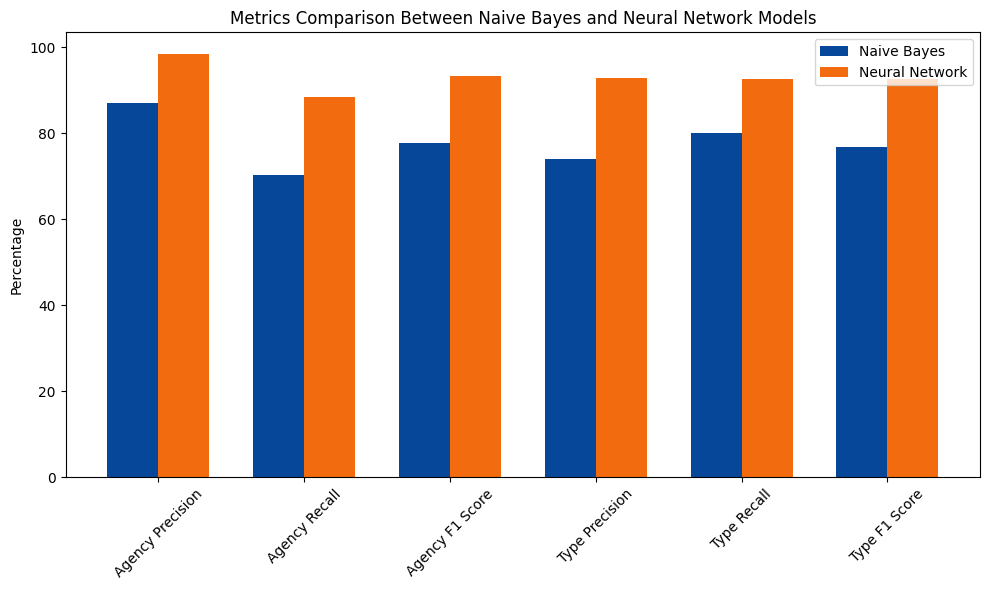

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [47]:
#naive bayes and neural netwroks combined metrics
nn_nb_metrics = {
    "Agency Precision": {"Naive Bayes": round(precision_agency_test * 100, 2), "Neural Network": round(precision_agency * 100, 2)},
    "Agency Recall": {"Naive Bayes": round(recall_agency_test * 100, 2), "Neural Network": round(recall_agency * 100, 2)},
    "Agency F1 Score": {"Naive Bayes": round(f1_agency_test * 100, 2), "Neural Network": round(f1_agency * 100, 2)},
    "Type Precision": {"Naive Bayes": round(precision_type_test * 100, 2), "Neural Network": round(precision_type * 100, 2)},
    "Type Recall": {"Naive Bayes": round(recall_type_test * 100, 2), "Neural Network": round(recall_type * 100, 2)},
    "Type F1 Score": {"Naive Bayes": round(f1_type_test * 100, 2), "Neural Network": round(f1_type * 100, 2)}
}

labels = list(nn_nb_metrics.keys())
nb_values = [nn_nb_metrics[label]["Naive Bayes"] for label in labels]
nn_values = [nn_nb_metrics[label]["Neural Network"] for label in labels]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, nb_values, width, label='Naive Bayes', color='#074799')
ax.bar(x + width/2, nn_values, width, label='Neural Network', color='#F26B0F')

ax.set_ylabel('Percentage')
ax.set_title("Metrics Comparison Between Naive Bayes and Neural Network Models")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()